In [1]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.svm import SVC
from sklearn.metrics import hinge_loss
from kl.utils import load_fx
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


# Define the quantum circuit for 8 qubits (one per feature)
def quantum_circuit(params, x):
    n_qubits = len(x)  # Ensure we are only working with 8 qubits
    for i in range(n_qubits):
        qml.RX(x[i], wires=i)  # Apply RX to qubit i with the i-th feature
        qml.RY(params[0], wires=i)
        qml.RZ(params[1], wires=i)
    
    # Measure the expectation value of Pauli-Z on all qubits
    # Return only a single vector of length 8 (one value per qubit)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define the quantum encoder
class QuantumEncoder(nn.Module):
    def __init__(self, n_qubits, n_features):
        super(QuantumEncoder, self).__init__()
        self.n_qubits = n_qubits
        self.n_features = n_features
        
        # Initialize the device with exactly 8 qubits
        self.dev = qml.device("default.qubit", wires=n_qubits)
        self.qcircuit = qml.QNode(quantum_circuit, self.dev)

    def forward(self, x):
        outputs = []
        params = torch.randn(2)  # Parameters for the quantum circuit
        print(f'x:{np.shape(x)}')
        # Loop through each sample in the batch
        for sample in x:
            sample = sample.detach().cpu().numpy()  # Convert sample to NumPy array for PennyLane
            # sample = sample[:self.n_qubits]  # Ensure we're only passing 8 features for 8 qubits
            output = self.qcircuit(params, sample)  # Process the whole sample at once
            
            # print(np.shape(output))
            
            # Ensure that the output is a vector of length 8
            # if np.shape(output) == (n_qubits, n_qubits):
            #     output = np.mean(output, axis=1)  # Take the mean if it's a matrix, to reduce to (8,)
            
            # Debugging: print output shape for each sample
            # print(f"Output shape for sample after correction: {np.shape(output)}")
            
            # Ensure output is a NumPy array of consistent shape
            outputs.append(np.array(output))  # Each output is a vector of qubit expectation values (length n_qubits)
        
        # Use np.stack() to ensure the outputs have consistent shape
        outputs_np = np.stack(outputs, axis=0)
        
        # Convert outputs to a tensor
        outputs_tensor = torch.tensor(outputs_np, dtype=torch.float32)
        # print(outputs_tensor.shape)
        return outputs_tensor  # Shape: [batch_size, n_qubits]
    
# Define the classical decoder
class ClassicalDecoder(nn.Module):
    def __init__(self, n_qubits, n_features):
        super(ClassicalDecoder, self).__init__()
        self.fc1 = nn.Linear(n_qubits, 128)  # Change input size from 1 to 8 to match latent vector size
        self.fc2 = nn.Linear(128, n_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Decode the quantum output
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


# Define the quantum VAE
class QuantumVAE(nn.Module):
    def __init__(self, n_qubits, n_features):
        super(QuantumVAE, self).__init__()
        self.encoder = QuantumEncoder(n_qubits, n_features)
        self.decoder = ClassicalDecoder(n_qubits, n_features)

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed_x = self.decoder(latent)
        return latent, reconstructed_x


In [2]:
def train_vae_with_svm(vae, dataloader, svm, optimizer, n_epochs=10):
    vae.train()
    svm_loss_weight = 0.1  # Hyperparameter to weight the SVM loss

    for epoch in range(n_epochs):
        total_loss = 0
        for batch in dataloader:
            # Unpack the batch data (features and labels)
            x, labels = batch  # Assuming DataLoader returns (X, y)
            # Convert 0/1 labels to -1/1 for hinge loss
            labels = labels * 2 - 1  # 0 -> -1, 1 -> 1
            
            # 1. Forward pass through VAE
            latent_vectors, reconstructed_x = vae(x)  # Get the latent space representation
            
            # 2. Train the SVM on the latent space
            # Fit the SVM on the latent vectors
            svm.fit(latent_vectors.detach().cpu().numpy(), labels.cpu().numpy())
            svm_score = svm.score(latent_vectors.detach().cpu().numpy(), labels.cpu().numpy())
            
            # 3. Calculate reconstruction loss
            recon_loss = nn.MSELoss()(reconstructed_x, x)
            
            # 4. (Optional) Calculate KL divergence (if applicable)
            # Calculate KL divergence (assuming Gaussian latent space)
            mu = torch.mean(latent_vectors, dim=0)
            log_var = torch.var(latent_vectors, dim=0).log()
            kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            
            # 5. Calculate the SVM hinge loss
            svm_predictions = svm.predict(latent_vectors.detach().cpu().numpy())
            svm_loss = hinge_loss(labels.cpu().numpy(), svm_predictions)
            
            # 6. Combine losses (Reconstruction, KL, and SVM Loss)
            # total_batch_loss = recon_loss + kl_divergence + svm_loss_weight * svm_loss
            total_batch_loss = recon_loss  + svm_loss_weight * svm_loss # remove KL div because is result that must increase
            # print(f'kl_divergence :{kl_divergence.item()}, svm_loss :{svm_loss}')
            total_loss += total_batch_loss.item()#1 - svm_score#
            
            # 7. Backpropagation and optimization
            optimizer.zero_grad()
            total_batch_loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{n_epochs}], recon_loss : {recon_loss:.4f}, kl_divergence :{kl_divergence.item():.4f}, svm_loss :{svm_loss:.4f}, svm_score :{svm_score:.4f}, total_loss : {total_loss/len(dataloader):.4f}')
        # print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {total_loss/len(dataloader)}')

    return vae

In [3]:

from sklearn.preprocessing import MinMaxScaler

X, y = load_fx(data_start=0, data_end=5000, shift=1)
scaler = MinMaxScaler(feature_range=(-np.pi / 2, np.pi / 2))
X_scaled = scaler.fit_transform (X)

In [4]:

# Assuming you already have your data loaded as X, y
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create a DataLoader for batching
batch_size = 64
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [5]:
print(X_tensor.shape, y.shape)

torch.Size([4990, 8]) (4990,)


In [6]:
print(f'X_tensor - > Mean : {X_tensor.mean()}, Std : {X_tensor.std()}, min : {X_tensor.min()}, max : {X_tensor.max()}')

X_tensor - > Mean : -0.013602559454739094, Std : 0.6194427609443665, min : -1.5707963705062866, max : 1.5707963705062866


In [7]:

#Assuming a dataloader and optimizer have been set up, and an SVM classifier initialized:
vae = QuantumVAE(n_qubits=8, n_features=8)
# svm = SVC(kernel='linear')  # Linear SVM
# Increase the regularization strength or try different kernels
# svm = SVC(C=10, kernel='rbf')
# svm = SVC(C=100, kernel='linear')  # Reduce C to avoid overfitting
svm = SVC(C=10, kernel='rbf')# my random guest
LR = 0.00001#0.0001 -> second  #0.001->initial
optimizer = optim.Adam(vae.parameters(), lr=LR)
# Train the model
vae_trained = train_vae_with_svm(vae, dataloader, svm, optimizer, n_epochs=1)

x:torch.Size([64, 8])
x:torch.Size([64, 8])
x:torch.Size([64, 8])
x:torch.Size([64, 8])
x:torch.Size([64, 8])
x:torch.Size([64, 8])
x:torch.Size([64, 8])
x:torch.Size([64, 8])
x:torch.Size([64, 8])
x:torch.Size([64, 8])
x:torch.Size([64, 8])
x:torch.Size([64, 8])
x:torch.Size([64, 8])
x:torch.Size([64, 8])
x:torch.Size([64, 8])
x:torch.Size([64, 8])
x:torch.Size([64, 8])
x:torch.Size([64, 8])
x:torch.Size([64, 8])
x:torch.Size([64, 8])
x:torch.Size([64, 8])
x:torch.Size([64, 8])
x:torch.Size([64, 8])
x:torch.Size([64, 8])


KeyboardInterrupt: 

In [438]:
def run_inference(vae, dataloader):
    vae.eval()  # Set the model to evaluation mode (no gradient updates)

    all_reconstructed_predictions = []
    all_latents = []
    
    for batch in dataloader:
        # Unpack the batch data
        x, _ = batch  # No need for labels in inference
        
        # Pass the input through the VAE (quantum encoder + classical decoder)
        latent_vectors, reconstructed_x = vae(x)
        
        # In a classification task, you may want to output the latent vectors or use the reconstructed output
        all_reconstructed_predictions.append(reconstructed_x.detach().cpu().numpy())
        all_latents.append(latent_vectors.detach().cpu().numpy())
    
    return np.concatenate(all_latents, axis=0), np.concatenate(all_reconstructed_predictions, axis=0)

In [439]:
latent, reconstructed = run_inference(vae_trained, dataloader) 

In [440]:
labels = y * 2 - 1  # 0 -> -1, 1 -> 1
np.savetxt('latent_q.txt', latent)
np.savetxt('reconstructed_q.txt', reconstructed)
np.savetxt('y_q.txt', labels)

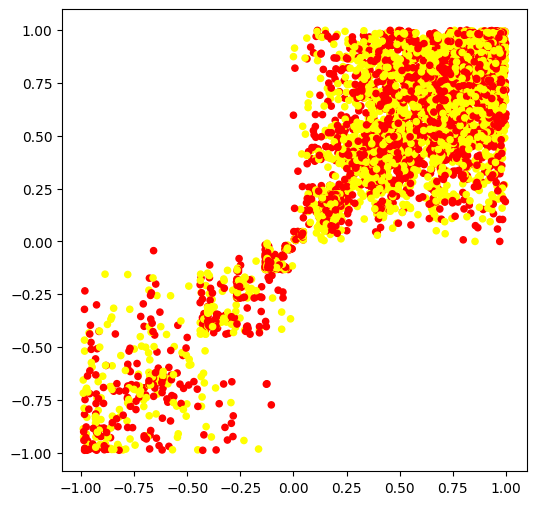

In [441]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(latent[:, 0], latent[:, 1], cmap="autumn", c=labels, s=20)

In [ ]:
print(f'Latent vectors shape : {latent.shape}')

In [ ]:
import pacmap
import numpy as np
import matplotlib.pyplot as plt

# loading preprocessed coil_20 dataset
# you can change it with any dataset that is in the ndarray format, with the shape (N, D)
# where N is the number of samples and D is the dimension of each sample
Xr = reconstructed
Xr = Xr.reshape(Xr.shape[0], -1)
# y = np.load("./data/coil_20_labels.npy", allow_pickle=True)

# initializing the pacmap instance
# Setting n_neighbors to "None" leads to an automatic choice shown below in "parameter" section
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=10, MN_ratio=0.5, FP_ratio=2.0) 

# fit the data (The index of transformed data corresponds to the index of the original data)
X_transformed = embedding.fit_transform(Xr, init="pca")
# X_transformed = embedding.fit_transform(Xr, init=None)

# visualize the embedding
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(X_transformed[:, 0], X_transformed[:, 1], cmap="autumn", c=y, s=20)


In [ ]:
# a81c40df80b2f0e4fc44eb019f0c411a0e73a97d915664e57a75c28697c0f4bc3a7d511cf3fcf7dc52131a94b7e94bf950ca8382f1f8b6259157045bbfeb3e97

In [ ]:
# a81c40df80b2f0e4fc44eb019f0c411a0e73a97d915664e57a75c28697c0f4bc3a7d511cf3fcf7dc52131a94b7e94bf950ca8382f1f8b6259157045bbfeb3e97

In [ ]:
from qiskit_ibm_provider import IBMProvider

# Save your credentials on disk.
# IBMProvider.save_account(token='<IBM Quantum API key>')

provider = IBMProvider(instance='ibm-q/open/main')

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

token = 'a81c40df80b2f0e4fc44eb019f0c411a0e73a97d915664e57a75c28697c0f4bc3a7d511cf3fcf7dc52131a94b7e94bf950ca8382f1f8b6259157045bbfeb3e97'
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token=token
)

# Or save your credentials on disk.
QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token=token)

In [ ]:
# List available backends
backends = service.backends()

In [ ]:
print(backends)
# Print properties of each backend
for backend in backends:
    print(f"Backend: {backend.acquire_channel(qubit=8)}, Qubits: {backend.configuration().n_qubits}, status:{backend.status().status_msg}")

In [ ]:
n_qubits = backends[0].configuration().n_qubits

In [ ]:
# Define a device using PennyLane and the backend you selected from IBM Quantum
dev = qml.device('qiskit.remote', wires=n_qubits, backend=backends[0])

In [ ]:
@qml.qnode(dev)
def quantum_circuit(params):
    for i in range(n_qubits):
        qml.RX(params[i], wires=i)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Run the quantum circuit
params = [0.1 * i for i in range(n_qubits)]
result = quantum_circuit(params)
print(result)

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='a81c40df80b2f0e4fc44eb019f0c411a0e73a97d915664e57a75c28697c0f4bc3a7d511cf3fcf7dc52131a94b7e94bf950ca8382f1f8b6259157045bbfeb3e97'
)
job = service.job('cvj3kx7z17rg008djnt0')
job_result = job.result()

for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs}")

In [ ]:
quantum_result =  job_result[0].data.evs
import matplotlib.pyplot as plt
import numpy as np

#e histogram
plt.hist(quantum_result, bins=20, edgecolor='black', alpha=0.7)
plt.title('Histogram of Quantum Results')
plt.xlabel('Measurement Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
print(f'Quantum result: min: {np.min(quantum_result)}, max: {np.max(quantum_result)}, mean: {np.mean(quantum_result)}, std: {np.std(quantum_result)}, shape: {quantum_result.shape}')

In [ ]:
params_array = np.array(params)

In [ ]:
params_array

In [ ]:
print(f'params_array: min: {np.min(params_array)}, max: {np.max(params_array)}, mean: {np.mean(params_array)}, std: {np.std(params_array)}, shape: {params_array.shape}')